### Team info

Teodor Barane Lindell. Student nummer: 565706

Jonas Brigsten Olsen. Student nummer: 545477

Henrik Log Jacobsen. Student nummer: 529212

Team name: Lei-Cheng FC

# Short notebook 1
To reproduce submission 'catboost_prelag_17.csv' with Public score: 150.254739

In [1]:
# IMPORTS 

import numpy as np
import warnings
import matplotlib.pylab as plt
import pandas as pd
from catboost import CatBoostRegressor

# Import Data Manager

In [2]:
# DM CLASS
 
class Data_Manager() : 

    def __init__(self) : 
        # Y_train
        self.train_a = pd.DataFrame() 
        self.train_b = pd.DataFrame()
        self.train_c = pd.DataFrame()

        self.X_train_observed_a = pd.DataFrame()
        self.X_train_observed_b = pd.DataFrame()
        self.X_train_observed_c = pd.DataFrame()

        self.X_train_estimated_a = pd.DataFrame()
        self.X_train_estimated_b = pd.DataFrame()
        self.X_train_estimated_c = pd.DataFrame()

        self.X_test_estimated_a = pd.DataFrame()
        self.X_test_estimated_b = pd.DataFrame()
        self.X_test_estimated_c = pd.DataFrame()

        self.data_A = pd.DataFrame()    
        self.data_B = pd.DataFrame()
        self.data_C = pd.DataFrame()

        self.data = pd.DataFrame()
        self.X_test_estimated = pd.DataFrame()

        # X_train_obs, Y_train_obs
        self.data_A_obs = pd.DataFrame()    
        self.data_B_obs = pd.DataFrame()
        self.data_C_obs = pd.DataFrame()
        
        # X_train_obs, Y_train_obs
        self.data_A_es = pd.DataFrame()
        self.data_B_es = pd.DataFrame()
        self.data_C_es = pd.DataFrame()

        self.amplitude = np.zeros(3) # amp_a, amp_b, amp_c

    def data_loader(self): 
        """
        Function that loads the datasets into data manager, loads all data 
        """

        self.train_a = pd.read_parquet('A/train_targets.parquet')
        self.train_a = self.train_a.rename(columns={"time":"date_forecast"})

        self.train_b = pd.read_parquet('B/train_targets.parquet')
        self.train_b = self.train_b.rename(columns={"time":"date_forecast"})

        self.train_c = pd.read_parquet('C/train_targets.parquet')
        self.train_c = self.train_c.rename(columns={"time":"date_forecast"})

        self.X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
        self.X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
        self.X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

        self.X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
        self.X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
        self.X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

        self.X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
        self.X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
        self.X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')
    
    def dms2dm(self, dms):
        self.train_a = dms.data['train_a']
        self.train_b = dms.data['train_b']
        self.train_c = dms.data['train_c']

        self.X_train_estimated_a = dms.data['X_train_estimated_a']
        self.X_train_estimated_b = dms.data['X_train_estimated_b']
        self.X_train_estimated_c = dms.data['X_train_estimated_c']

        self.X_train_observed_a = dms.data['X_train_observed_a']
        self.X_train_observed_b = dms.data['X_train_observed_b']
        self.X_train_observed_c = dms.data['X_train_observed_c']

        self.X_test_estimated_a = dms.data['X_test_estimated_a']
        self.X_test_estimated_b = dms.data['X_test_estimated_b']
        self.X_test_estimated_c = dms.data['X_test_estimated_c']

        self.data_A_obs = dms.data['data_A_obs']
        self.data_B_obs = dms.data['data_B_obs']
        self.data_C_obs = dms.data['data_C_obs']

        self.data_A_es = dms.data['data_A_es']
        self.data_B_es = dms.data['data_B_es']
        self.data_C_es = dms.data['data_C_es']

        self.data_A = dms.data['data_A']   
        self.data_B = dms.data['data_B']
        self.data_C = dms.data['data_C']

        self.amplitude = dms.data['amplitude']

    def drop_feature(self, datasets:list[pd.DataFrame], features:list[str]):
        """
        Takes in list of datasets and removes features from the sets

        Returns list of altered datasets
        """

        altered_sets = []

        for set in datasets: 
            for feature in features:

                set = set.drop(feature, axis=1)

            altered_sets.append(set)

        return altered_sets
    
    def combine_data(self): 
        """
        Combines datasets A, B and C into one set containing all features and pv_measurements. 

        Combine_observed_estimated (bool) determines if you want one single set for A B C or keep the observed and estimated
        data split 

        Warning! Data should have no NaN values or be of same frequency before combining! 
        """
        weather_data_A = pd.concat([self.X_train_observed_a, self.X_train_estimated_a], axis=0, ignore_index=True)
        weather_data_B = pd.concat([self.X_train_observed_b, self.X_train_estimated_b], axis=0, ignore_index=True)
        weather_data_C = pd.concat([self.X_train_observed_c, self.X_train_estimated_c], axis=0, ignore_index=True)

        self.data_A = pd.merge(weather_data_A, self.train_a, how="left", on="date_forecast")
        self.data_B = pd.merge(weather_data_B, self.train_b,  on="date_forecast", how="left")
        self.data_C = pd.merge(weather_data_C, self.train_c, on="date_forecast", how="left")

        if ( self.data_A.columns.__contains__("date_calc") ): 
            self.data_A = self.data_A.drop("date_calc", axis=1)
            self.data_B = self.data_B.drop("date_calc", axis=1)
            self.data_C = self.data_C.drop("date_calc", axis=1)

        if (self.train_a.shape[0] > 35000 ) : 
            
            self.data_A = self.makima_interpolate(self.data_A).dropna()
            self.data_B = self.makima_interpolate(self.data_B).dropna()
            self.data_C = self.makima_interpolate(self.data_C).dropna()
        
        elif (self.train_a.shape[0] < 35000) : 
            self.data_A = self.data_A.dropna()
            self.data_B = self.data_B.dropna()
            self.data_C = self.data_C.dropna()

        if self.data_A.isna().sum().sum() > 0 :
            warnings.warn("Warning! Data should have no NaN values or be of same frequency before combining! Use impute or interpolation on data before combining! This could also come from dates in the combined datasets not overlapping fully.")

        return self.data_A, self.data_B, self.data_C

    def impute_data(self, datasets, advanced_imputer=False):

        """
        imputes data to fill in missing values

        takes in a list of datasets

        returns list of imputed data

        removes all columns consisting entirely of nan 
        """

        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer, SimpleImputer
        from tqdm import tqdm
        imputed_sets = []

        for set in tqdm(datasets): 

            # storing columns to lable after impute, also removing date column as this does not work with impute 
            cols = set.columns 

            if set.columns.__contains__("date_forecast"): 
                dates = set["date_forecast"]
            
            if set.columns.__contains__("date_calc"): 
                set = set.drop("date_calc", axis=1)

            cols = set.columns.delete(0)

            set_wo_date = set.drop("date_forecast", axis=1)

            #imputing (estimating) missing values 
            imp = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=False)
            imp.fit(set_wo_date)
            set_wo_date = pd.DataFrame(imp.transform(set_wo_date), columns=imp.get_feature_names_out())
            

            # setting column lables basck
            set = set_wo_date
            
            set["date_forecast"] = dates

            #sorting columns 
            cols = cols.tolist()
            cols.insert(0, "date_forecast")

            #set = set.fillna(0.0)

            imputed_sets.append(set)

        return imputed_sets
    
    def iterative_imputer(self, datasets) :

        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer, SimpleImputer
        from tqdm import tqdm
        imputed_sets = []
        imp = IterativeImputer(random_state=0, missing_values=np.nan, add_indicator=False, imputation_order="ascending", skip_complete=True)

        for set in tqdm(datasets): 

            cols = set.columns 

            if set.columns.__contains__("date_forecast"): 
                dates = set["date_forecast"]
            
            if set.columns.__contains__("date_calc"): 
                set = set.drop("date_calc", axis=1)
            
            cols = set.columns.delete(0)

            set_wo_date = set.drop("date_forecast", axis=1)

            print("getting to imputing")
            #imputing (estimating) missing values 
            imp.fit(set_wo_date)
            
            set_wo_date = pd.DataFrame(imp.transform(set_wo_date), columns=imp.get_feature_names_out())

             # setting column lables basck
            set = set_wo_date
            
            set["date_forecast"] = dates

            # set = set.fillna(0.0)


            #sorting columns 
            cols = cols.tolist()
            cols.insert(0, "date_forecast")

            imputed_sets.append(set)

        return imputed_sets

    def resample_data(self, datasets, freq) : 


        """
        resamples the given dataset into the correct frequency. 
        H : hourly 
        15T : 15min 
        """

        corr = []

        for set in datasets: 
            set_hourly = set.resample(freq, on="date_forecast").mean()

            set_dates = set["date_forecast"].dt.date.unique().tolist()

            set_hourly["date_forecast"] = set_hourly.index

            set_corr = set_hourly[set_hourly["date_forecast"].dt.date.isin(set_dates)]

            set_corr.index = pd.RangeIndex(0, len(set_corr))
            corr.append(set_corr)

        
        return corr

    def add_feature(dataset, feature_name, data) :

        added_set = dataset[feature_name] = data

        return added_set
    
    def set_info(self, dataset:pd.DataFrame):

        (dataset.info())

    def plot_feature(self, dataset:pd.DataFrame, featureName:str):
        
        fig, axs = plt.subplots(1, 1, figsize=(20, 10))

        dataset[['date_forecast', featureName]].set_index("date_forecast").plot(ax=axs, title=featureName, color='red')
       
    def KNNImputing(self, datasets) :
        from sklearn.impute import KNNImputer
        from tqdm import tqdm

        imputed_sets = []

        for set in tqdm(datasets): 

            # storing columns to lable after impute, also removing date column as this does not work with impute 
            cols = set.columns 

            if set.columns.__contains__("date_forecast"): 
                dates = set["date_forecast"]
            
            if set.columns.__contains__("date_calc"): 
                set = set.drop("date_calc", axis=1)

            cols = set.columns.delete(0)

            set_wo_date = set.drop("date_forecast", axis=1)

            #imputing (estimating) missing values 
            imp = KNNImputer(n_neighbors=40, weights="distance", )
            imp.fit(set_wo_date)
            set_wo_date = pd.DataFrame(imp.transform(set_wo_date), columns=imp.get_feature_names_out())
            

            # setting column lables basck
            set = set_wo_date
            
            set["date_forecast"] = dates

            #sorting columns 
            cols = cols.tolist()
            cols.insert(0, "date_forecast")

            ## set = set.fillna(0.0)

            imputed_sets.append(set)

        return imputed_sets

    def makima_interpolate(self, data: pd.DataFrame) -> pd.DataFrame:

        from scipy.interpolate import Akima1DInterpolator
        # Extract non-missing values and their indices

        dates = data["date_forecast"]

        non_nan_indices = data['pv_measurement'].dropna().index
        non_nan_values = data['pv_measurement'].dropna().values

        # Apply the Modified Akima Interpolation
        akima = Akima1DInterpolator(non_nan_indices, non_nan_values)
        interpolated_values = akima(data.index)

        # Replace the original column with the interpolated values
        data['pv_measurement'] = interpolated_values

        data[data["pv_measurement"]< 0] = 0 ; 

        data["date_forecast"] = dates; 

        return data
    
    def normalize_data(self) : 
        from sklearn import preprocessing

        if (self.data_A.empty) : 
            print( "empty ")
            relevant_sets = [attr for attr in dir(self) if not callable(getattr(self, attr)) and not attr.startswith("__") and not attr.__contains__("data") and not attr == 'amplitude' and not attr.__contains__("normalizing")]

        else: 
            print("not emptu")
            relevant_sets = [attr for attr in dir(self) if not callable(getattr(self, attr)) and not attr.startswith("__") and attr.__contains__("data_") and not attr.__contains__("_es") and not attr.__contains__("obs") or attr.__contains__("_estimated_")]
        self.__setattr__("normalizing_consts", {})

        print(relevant_sets)

        min_max_scaler = preprocessing.MinMaxScaler()
        normalizer = preprocessing.Normalizer()
        

        for att in relevant_sets: 
            set : pd.DataFrame = self.__getattribute__(att)

            cols = set.columns 

            if set.columns.__contains__("date_forecast"): 
                dates = set["date_forecast"]
            
            if set.columns.__contains__("date_calc"): 
                set = set.drop("date_calc", axis=1)

            cols = set.columns.delete(0)

            set_wo_date = set.drop("date_forecast", axis=1)

            x = set_wo_date.values

            x_normalized = min_max_scaler.fit_transform(x)

            self.normalizing_consts[att] = (set_wo_date.min(), np.abs(set_wo_date.max() - set_wo_date.min())) ## storing normalizing consts for later 
            
            normalized_set = pd.DataFrame(x_normalized)

            normalized_set.columns = cols

            

            self.__setattr__(att, normalized_set)
        
    def scaling(self, preds, location:str) : 

        """
        FORMAT OF PREDICTIONS SHOULD BE 1 COLUMN WITH PREDS

        LOCATION: A B or C
        """

        relevant_sets = [attr for attr in dir(self) if not callable(getattr(self, attr)) and not attr.startswith("__") and not attr.__contains__("data") and not attr == 'amplitude' and (attr.__contains__("train_a") or attr.__contains__("train_b") or attr.__contains__("train_c"))]
        if (self.data_A.empty) : 
            print( "empty ")
            relevant_sets = [attr for attr in dir(self) if not callable(getattr(self, attr)) and not attr.startswith("__") and not attr.__contains__("data") and not attr == 'amplitude' and not attr.__contains__("normalizing")]

        else: 
            print("not emptu")
            relevant_sets = [attr for attr in dir(self) if not callable(getattr(self, attr)) and not attr.startswith("__") and attr.__contains__("data_") and not attr.__contains__("es") and not attr.__contains__("obs")]

        
        loc_index = 0

        if location.capitalize() == "A" :

            loc_index = 0

        elif location.capitalize() == "B": 
        
            loc_index = 1

        elif location.capitalize() == "C": 

            loc_index = 2
           
        elif ( location.capitalize() == "D"): 

            A = pd.DataFrame(preds[0:720])
            B = pd.DataFrame(preds[720:2*720])
            C = pd.DataFrame(preds[2*720:])

            min = self.normalizing_consts["data_A"][0][0]
            diff = self.normalizing_consts["data_A"][1][0]

            scaled_A = (A+min) * diff



            min = self.normalizing_consts["data_B"][0][0]
            diff = self.normalizing_consts["data_B"][1][0]

            scaled_B = (B+min) * diff



            min = self.normalizing_consts["data_C"][0][0]
            diff = self.normalizing_consts["data_C"][1][0]

            scaled_C = (C+min) * diff


            print(A.shape)
            scaled_set = pd.concat([scaled_A, scaled_B, scaled_C])

            return scaled_set

        relevant_set = relevant_sets[loc_index]

    
        min = self.normalizing_consts[relevant_set][0][0]
        diff = self.normalizing_consts[relevant_set][1][0]

        scaled_set = (preds + min) * diff

        return scaled_set
    
    def combine_overlap_BC(self): 
        import math
        """
        This function is created for merging B and C to remove the nan values apparent when merging pv_measurement to the weather data
        This is because of the observation that B and C overlap and where one is missing the other fills in. 
        Must run combine data first to create data_A B C
        """

        original_B = self.data_B
        original_C = self.data_C  

        b2c_scaling = original_B["pv_measurement"].max()/original_C["pv_measurement"].max()

        print(b2c_scaling)      

        original_C[original_C.isnull()] = self.data_B
        original_B[original_B.isnull()] = self.data_C

        self.data_C = original_C.dropna()
        self.data_B = original_B.dropna()

    def sorting_columns_inMainSets(self):

        A = self.data_A 
        cols = A.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.remove("pv_measurement")
        cols.insert(0, "pv_measurement")
        cols.insert(0, "date_forecast")

        A = A[cols]
        self.data_A = A

        #------------------------------------------------------------# 

        B = self.data_B
        cols = B.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.remove("pv_measurement")
        cols.insert(0, "pv_measurement")
        cols.insert(0, "date_forecast")

        B = B[cols]
        self.data_B = B 

        #------------------------------------------------------------#

        C = self.data_C

        cols = C.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.remove("pv_measurement")
        cols.insert(0, "pv_measurement")
        cols.insert(0, "date_forecast")

        C = C[cols]
        self.data_C = C

        #------------------------------------------------------------#

        A = self.X_test_estimated_a

        cols = A.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.insert(0, "date_forecast")

        A = A[cols]
        self.X_test_estimated_a = A

        #------------------------------------------------------------#

        B = self.X_test_estimated_b

        cols = B.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.insert(0, "date_forecast")

        B = B[cols]
        self.X_test_estimated_b = B

        #------------------------------------------------------------#

        C = self.X_test_estimated_c

        cols = C.columns.tolist()

        #sorting columns 
        cols.remove("date_forecast")
        cols.insert(0, "date_forecast")

        C = C[cols]
        self.X_test_estimated_c = C

        #------------------------------------------------------------#

        if ( not self.data.empty) : 
            data = self.data

            cols = data.columns.tolist()

            #sorting columns 
            cols.remove("date_forecast")
            cols.insert(0, "date_forecast")

            data = data[cols]
            self.data = data

    def remove_constant_periods(self, period_length, ignore_values=[]) :
        train_a = self.data_A.reset_index(drop=True)
        train_b = self.data_B.reset_index(drop=True)
        train_c = self.data_C.reset_index(drop=True)

        y_train_a_const_idx, ca = find_const_interval(train_a, 'pv_measurement', period_length, ignore_values)
        print('y_train_a anomalies:',ca)

        y_train_b_const_idx, cb = find_const_interval(train_b, 'pv_measurement', period_length, ignore_values)
        print('y_train_b anomalies:',cb)

        y_train_c_const_idx, cc = find_const_interval(train_c, 'pv_measurement', period_length, ignore_values)
        print('y_train_c anomalies:',cc)


        date_forecast_a_const = train_a.iloc[y_train_a_const_idx]['date_forecast']
        date_forecast_a_const_values = date_forecast_a_const.values
        train_a = train_a[~train_a['date_forecast'].isin(date_forecast_a_const_values)]

        date_forecast_b_const = train_b.iloc[y_train_b_const_idx]['date_forecast']
        date_forecast_b_const_values = date_forecast_b_const.values
        train_b = train_b[~train_b['date_forecast'].isin(date_forecast_b_const_values)]

        date_forecast_c_const = train_c.iloc[y_train_c_const_idx]['date_forecast']
        date_forecast_c_const_values = date_forecast_c_const.values
        train_c = train_c[~train_c['date_forecast'].isin(date_forecast_c_const_values)]

        self.data_A = train_a
        self.data_B = train_b
        self.data_C = train_c
                
    def split_timeseries(self, X, y, num_splits):

        num_rows = X.shape[0]

        split_length = num_rows // num_splits

        all_splits = []

        end_idx = split_length

        all_splits.append([np.arange(0, round(split_length*0.9), 1), np.arange(round(split_length*0.9), split_length, 1)])


        while 2*end_idx < num_rows: 

            all_splits.append([np.arange(round(end_idx), end_idx + round(0.9*end_idx), 1), np.arange(round(end_idx*0.9)+end_idx, 2*end_idx, 1)])

            end_idx += split_length

        print(end_idx + split_length)
        rest = num_rows - end_idx 

        all_splits.append([np.arange(round(2), )])

        print(all_splits) 

    def add_location(self, dataset:pd.DataFrame, location):

        if location == "A": loc = 0 
        if location == "B": loc = 1 
        if location == "C": loc = 2

        index = dataset.index

        loc_column = pd.DataFrame()
        loc_column.index = index
        loc_column["location"] = loc

        dataset["location"] = loc

        return dataset
    
    def add_lag_feature(self, target_attribute, lag):

        lag_attribute = target_attribute + "_lag_" + str(lag)

        self.data_A[lag_attribute] = self.data_A[target_attribute].shift(lag).fillna(0)
        self.data_B[lag_attribute] = self.data_B[target_attribute].shift(lag).fillna(0)
        self.data_C[lag_attribute] = self.data_C[target_attribute].shift(lag).fillna(0)

        self.X_test_estimated_a[lag_attribute] = self.X_test_estimated_a[target_attribute].shift(lag).fillna(0)
        self.X_test_estimated_b[lag_attribute] = self.X_test_estimated_b[target_attribute].shift(lag).fillna(0)
        self.X_test_estimated_c[lag_attribute] = self.X_test_estimated_c[target_attribute].shift(lag).fillna(0)

        

    def combine_all_data(self): 

        relevant_sets_A = [attr for attr in dir(self) if attr.__eq__("data_A") or attr.__eq__("X_test_estimated_a")]
        relevant_sets_B = [attr for attr in dir(self) if attr.__eq__("data_B") or attr.__eq__("X_test_estimated_b")]
        relevant_sets_C = [attr for attr in dir(self) if attr.__eq__("data_C") or attr.__eq__("X_test_estimated_c")]

        print(relevant_sets_A)
        print(relevant_sets_B)
        print(relevant_sets_C)


        for set in relevant_sets_A : 
            self.__setattr__(set, self.add_location(self.__getattribute__(set), "A"))
        for set in relevant_sets_B : 
            self.__setattr__(set, self.add_location(self.__getattribute__(set), "B"))
        for set in relevant_sets_C : 
            self.__setattr__(set, self.add_location(self.__getattribute__(set), "C"))


        self.data = pd.concat([self.data_A, self.data_B, self.data_C], ignore_index=True)
        self.X_test_estimated = pd.concat([self.X_test_estimated_a, self.X_test_estimated_b, self.X_test_estimated_c], ignore_index=True)

    def remove_outliers_z_score(self, data:pd.DataFrame, threshold=3) : 
        
        from scipy import stats

        before = self.data["diffuse_rad:W"][0:3*720]

        dates = None 

        if "date_forecast" in data.columns: 

            dates = data["date_forecast"]
            data = data.drop("date_forecast", axis=1)

        z_scores = stats.zscore(data.astype(float))

        outliers = data[z_scores > threshold]
        outliers = outliers.notna()

        indexx = None

        if (len(outliers) > 1): 

            for outlier in outliers: 
                if (outlier != "index"):

                    index = data[outlier].loc[outliers[outlier] == True]

                    data[outlier] = data[outlier].replace(index.index, np.nan)


                    indexx = index
            

            data["date_forecast"] = dates

            data = self.KNNImputing([data])[0]
            data = data.reset_index(drop=True)
            self.sorting_columns_inMainSets()
            print(self.set_info(self.data))
            
            x = np.arange(0, 3*720, 1)
            fig, axs = plt.subplots(1, 1, figsize=(20, 10))
            plt.plot(x, before, c="blue", label="before")            
            plt.plot(x, data["diffuse_rad:W"][0:3*720], c="orange", label="after") 
            plt.legend()           
            plt.show()
            return data

        else: 
            print("no outliers")
            return data

# Import Helper functions

In [3]:
# HELPERS

def impute (datasets: list[pd.DataFrame]) : 

    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer, SimpleImputer
    import numpy as np
    import pandas as pd
    

    imputed_sets = []

    for set in datasets: 

        # storing columns to lable after impute, also removing date column as this does not work with impute 
        cols = set.columns 

        if set.columns.__contains__("date_forecast"): 
            dates = set["date_forecast"]
        
        if set.columns.__contains__("date_calc"): 
            set = set.drop("date_calc", axis=1)

        cols = set.columns.delete(0)

        set_wo_date = set.drop("date_forecast", axis=1)

        #imputing (estimating) missing values 
        imp = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=False)
        imp.fit(set_wo_date)
        set_wo_date = imp.transform(set_wo_date)
        set_wo_date = pd.DataFrame(set_wo_date)

        # setting column lables basck
        set = set_wo_date
        set.columns = set.columns.astype(str)
        set.columns = cols
        set["date_forecast"] = dates

        #sorting columns 
        cols = cols.tolist()
        cols.insert(0, "date_forecast")

        set = set[cols]

        set = set.fillna(0.0)

        imputed_sets.append(set)

    return imputed_sets

def drop_feature(datasets:list[pd.DataFrame], features:list[str]):

    altered_sets = []

    for set in datasets: 
        for feature in features:

            set = set.drop(feature, axis=1)

        altered_sets.append(set)

    return altered_sets

def find_const_interval(df, target_attribute, interval_length, ignore_values=[]):
    """
    Find all the intervals of the given length in the dataset where the target_attribute is constant.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    target_attribute (str): The target attribute to check for constant values.
    interval_length (int): The length of the interval to search for.

    Returns:
    list: A list of indexes of all the values in the intervals where the target_attribute is constant for the given interval length or bigger.
    """
    idxs = []
    intervals_found = 0
    i = 0
    while i + interval_length < len(df) - 1:
        if df[target_attribute][i:i+interval_length].nunique() == 1 and df[target_attribute][i] not in ignore_values:
            j = i + interval_length - 1
            value = df[target_attribute][i]
            while value == df[target_attribute][j] and j < len(df) - 1:
                j += 1
            idxs.extend(list(range(i, j)))
            i = j+2
            intervals_found += 1
        else:
            i += 1
    return idxs, intervals_found

def donate_missing_rows(reciever, donor, target_attribute = 'date_forecast', scalepv = False):
    """
    Add rows from donor to reciever where the target_attribute is missing in reciever.

    Parameters:
    reciever (pandas.DataFrame): The dataframe to add rows to.
    donor (pandas.DataFrame): The dataframe to add rows from.
    target_attribute (str): The target attribute to check for missing values.

    Returns:
    tuple: A tuple containing the updated reciever dataframe and the number of rows that were donated.
    """
    donor_copy = donor.copy()
    if scalepv:
        scale = reciever['pv_measurement'].mean() / donor['pv_measurement'].mean()
        donor_copy['pv_measurement'] = donor_copy['pv_measurement'] * scale

    donated_rows = 0
    for date in donor_copy[target_attribute]:
        if date not in reciever[target_attribute].values:
            new_row = donor_copy[donor_copy[target_attribute] == date]
            reciever = pd.concat([reciever, new_row], ignore_index=True)
            donated_rows += 1
    reciever = reciever.sort_values(target_attribute).reset_index(drop=True)

    return reciever, donated_rows

## Import Data

In [4]:
# IMPORT DATA

# instanciate a new datamanager 
dm = Data_Manager()
# loads all data into the datamanager 
dm.data_loader()

FileNotFoundError: [Errno 2] No such file or directory: 'A/train_targets.parquet'

# Data Preparation

In [ ]:
# REMOVING FEATURES WITH NULL VALUES

dm.X_train_observed_a = dm.X_train_observed_a.drop("snow_density:kgm3", axis=1)
dm.X_train_observed_b = dm.X_train_observed_b.drop("snow_density:kgm3", axis=1) 
dm.X_train_observed_c = dm.X_train_observed_c.drop("snow_density:kgm3", axis=1) 

dm.X_train_estimated_a = dm.X_train_estimated_a.drop("snow_density:kgm3", axis=1)
dm.X_train_estimated_b = dm.X_train_estimated_b.drop("snow_density:kgm3", axis=1)
dm.X_train_estimated_c = dm.X_train_estimated_c.drop("snow_density:kgm3", axis=1)

dm.X_train_observed_a = dm.X_train_observed_a.drop("ceiling_height_agl:m", axis=1)
dm.X_train_observed_b = dm.X_train_observed_b.drop("ceiling_height_agl:m", axis=1) 
dm.X_train_observed_c = dm.X_train_observed_c.drop("ceiling_height_agl:m", axis=1) 
dm.X_train_estimated_a = dm.X_train_estimated_a.drop("ceiling_height_agl:m", axis=1)
dm.X_train_estimated_b = dm.X_train_estimated_b.drop("ceiling_height_agl:m", axis=1)
dm.X_train_estimated_c = dm.X_train_estimated_c.drop("ceiling_height_agl:m", axis=1)

dm.X_train_observed_a = dm.X_train_observed_a.drop("cloud_base_agl:m", axis=1)
dm.X_train_observed_b = dm.X_train_observed_b.drop("cloud_base_agl:m", axis=1) 
dm.X_train_observed_c = dm.X_train_observed_c.drop("cloud_base_agl:m", axis=1) 
dm.X_train_estimated_a = dm.X_train_estimated_a.drop("cloud_base_agl:m", axis=1)
dm.X_train_estimated_b = dm.X_train_estimated_b.drop("cloud_base_agl:m", axis=1)
dm.X_train_estimated_c = dm.X_train_estimated_c.drop("cloud_base_agl:m", axis=1)

dm.X_test_estimated_a = dm.X_test_estimated_a.drop("cloud_base_agl:m", axis=1)
dm.X_test_estimated_b = dm.X_test_estimated_b.drop("cloud_base_agl:m", axis=1) 
dm.X_test_estimated_c = dm.X_test_estimated_c.drop("cloud_base_agl:m", axis=1) 

dm.X_test_estimated_a = dm.X_test_estimated_a.drop("ceiling_height_agl:m", axis=1)
dm.X_test_estimated_b = dm.X_test_estimated_b.drop("ceiling_height_agl:m", axis=1)
dm.X_test_estimated_c = dm.X_test_estimated_c.drop("ceiling_height_agl:m", axis=1)

dm.X_test_estimated_a = dm.X_test_estimated_a.drop("snow_density:kgm3", axis=1)
dm.X_test_estimated_b = dm.X_test_estimated_b.drop("snow_density:kgm3", axis=1)
dm.X_test_estimated_c = dm.X_test_estimated_c.drop("snow_density:kgm3", axis=1)

In [ ]:
# DOWNSAMPLING DATA TO HOURLY

resamples = dm.resample_data([dm.X_train_observed_a, 
                                   dm.X_train_observed_b, 
                                   dm.X_train_observed_c, 
                                   dm.X_train_estimated_a,
                                   dm.X_train_estimated_b,
                                   dm.X_train_estimated_c,
                                   dm.X_test_estimated_a,
                                   dm.X_test_estimated_b,
                                   dm.X_test_estimated_c], "H")

dm.X_train_observed_a = resamples[0]
dm.X_train_observed_b = resamples[1] 
dm.X_train_observed_c = resamples[2] 
dm.X_train_estimated_a = resamples[3]
dm.X_train_estimated_b = resamples[4]
dm.X_train_estimated_c = resamples[5]
dm.X_test_estimated_a = resamples[6]
dm.X_test_estimated_b = resamples[7]
dm.X_test_estimated_c = resamples[8]

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:264: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  set_hourly = set.resample(freq, on="date_forecast").mean()
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:264: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  set_hourly = set.resample(freq, on="date_forecast").mean()
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:264: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either

In [ ]:
# COMBINING DATA

dm.data_A, dm.data_B, dm.data_C = dm.combine_data()
dm.sorting_columns_inMainSets()

print(dm.data_A.shape, dm.data_B.shape, dm.data_C.shape, dm.data.shape)

dates_A = dm.data_A["date_forecast"]
dates_B = dm.data_B["date_forecast"]
dates_C = dm.data_C["date_forecast"]

(34061, 44) (32819, 44) (26071, 44) (0, 0)


In [ ]:
# ADDING LAG FEATURE

dm.add_lag_feature('direct_rad:W', -23)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:677: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X_test_estimated_a[lag_attribute] = self.X_test_estimated_a[target_attribute].shift(lag).fillna(0)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X_test_estimated_b[lag_attribute] = self.X_test_estimated_b[target_attribute].shift(lag).fillna(0)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000

In [ ]:
# REMOVING CONSTANT Y PERIODS

dm.remove_constant_periods(12)
dm.remove_constant_periods(3, [0])

y_train_a anomalies: 673
y_train_b anomalies: 651
y_train_c anomalies: 511
y_train_a anomalies: 0
y_train_b anomalies: 15
y_train_c anomalies: 58


In [ ]:
# BC DONATION

updated_b, count_b = donate_missing_rows(dm.data_B, dm.data_C)
print('donated rows from C to B: ', count_b)
updated_c, count_c = donate_missing_rows(dm.data_C, dm.data_B)
print('donated rows from B to C: ', count_c)
# set donated data
dm.data_B = updated_b
dm.data_C = updated_c

donated rows from C to B:  3213
donated rows from B to C:  6022


# Feature Engineering

In [ ]:
# MAKING MONTH_cosS ITS OWN FEATURE

def month_cos_func_cos(x): 
    return -6* np.cos(2*np.pi/12 * x) + 6


dm.data_A["month_cos"] = month_cos_func_cos((dm.data_A["date_forecast"]).dt.month)
dm.data_B["month_cos"] = month_cos_func_cos((dm.data_B["date_forecast"]).dt.month)
dm.data_C["month_cos"] = month_cos_func_cos((dm.data_C["date_forecast"]).dt.month)

dm.X_test_estimated_a["month_cos"] = month_cos_func_cos((dm.X_test_estimated_a["date_forecast"]).dt.month)
dm.X_test_estimated_b["month_cos"] = month_cos_func_cos((dm.X_test_estimated_b["date_forecast"]).dt.month)
dm.X_test_estimated_c["month_cos"] = month_cos_func_cos((dm.X_test_estimated_c["date_forecast"]).dt.month)


/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/2981058230.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["month_cos"] = month_cos_func_cos((dm.X_test_estimated_a["date_forecast"]).dt.month)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/2981058230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["month_cos"] = month_cos_func_cos((dm.X_test_estimated_b["date_forecast"]).dt.month)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr

In [ ]:
# MAKING MONTH_sinS ITS OWN FEATURE

def month_sin_func_sin(x): 
    return -6* np.sin(2*np.pi/12 * x) + 6


dm.data_A["month_sin"] = month_sin_func_sin((dm.data_A["date_forecast"]).dt.month)
dm.data_B["month_sin"] = month_sin_func_sin((dm.data_B["date_forecast"]).dt.month)
dm.data_C["month_sin"] = month_sin_func_sin((dm.data_C["date_forecast"]).dt.month)

dm.X_test_estimated_a["month_sin"] = month_sin_func_sin((dm.X_test_estimated_a["date_forecast"]).dt.month)
dm.X_test_estimated_b["month_sin"] = month_sin_func_sin((dm.X_test_estimated_b["date_forecast"]).dt.month)
dm.X_test_estimated_c["month_sin"] = month_sin_func_sin((dm.X_test_estimated_c["date_forecast"]).dt.month)


/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/3668392489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["month_sin"] = month_sin_func_sin((dm.X_test_estimated_a["date_forecast"]).dt.month)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/3668392489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["month_sin"] = month_sin_func_sin((dm.X_test_estimated_b["date_forecast"]).dt.month)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr

In [ ]:
# MAKING HOUR ITS OWN FEATURE

def hour_func_cos(x): 
    return -12*np.cos(2*np.pi/24 * x) + 12

dm.X_test_estimated_a["hours_cos"] = hour_func_cos(dm.X_test_estimated_a["date_forecast"].dt.hour)
dm.X_test_estimated_b["hours_cos"] = hour_func_cos(dm.X_test_estimated_b["date_forecast"].dt.hour)
dm.X_test_estimated_c["hours_cos"] = hour_func_cos(dm.X_test_estimated_c["date_forecast"].dt.hour)

dm.data_A["hours_cos"] =  hour_func_cos(dm.data_A["date_forecast"].dt.hour)
dm.data_B["hours_cos"] = hour_func_cos(dm.data_B["date_forecast"].dt.hour)
dm.data_C["hours_cos"] = hour_func_cos(dm.data_C["date_forecast"].dt.hour)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/674960304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["hours_cos"] = hour_func_cos(dm.X_test_estimated_a["date_forecast"].dt.hour)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/674960304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["hours_cos"] = hour_func_cos(dm.X_test_estimated_b["date_forecast"].dt.hour)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_1

In [ ]:
# MAKING HOUR ITS OWN FEATURE

def hour_func_sin(x): 
    return -12*np.sin(2*np.pi/24 * x) + 12

dm.X_test_estimated_a["hours_sin"] = hour_func_sin(dm.X_test_estimated_a["date_forecast"].dt.hour)
dm.X_test_estimated_b["hours_sin"] = hour_func_sin(dm.X_test_estimated_b["date_forecast"].dt.hour)
dm.X_test_estimated_c["hours_sin"] = hour_func_sin(dm.X_test_estimated_c["date_forecast"].dt.hour)

dm.data_A["hours_sin"] =  hour_func_sin(dm.data_A["date_forecast"].dt.hour)
dm.data_B["hours_sin"] = hour_func_sin(dm.data_B["date_forecast"].dt.hour)
dm.data_C["hours_sin"] = hour_func_sin(dm.data_C["date_forecast"].dt.hour)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1555246956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["hours_sin"] = hour_func_sin(dm.X_test_estimated_a["date_forecast"].dt.hour)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1555246956.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["hours_sin"] = hour_func_sin(dm.X_test_estimated_b["date_forecast"].dt.hour)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel

In [ ]:
# MAKING WEEK ITS OWN FEATURE

def week_func_cos(x): 
    return -26*np.cos(2*np.pi/52 * x) + 26

dm.X_test_estimated_a["week_number_cos"] = week_func_cos(dm.X_test_estimated_a["date_forecast"].dt.isocalendar().week)
dm.X_test_estimated_b["week_number_cos"] = week_func_cos(dm.X_test_estimated_b["date_forecast"].dt.isocalendar().week)
dm.X_test_estimated_c["week_number_cos"] = week_func_cos(dm.X_test_estimated_c["date_forecast"].dt.isocalendar().week)

dm.data_A["week_number_cos"] =  week_func_cos(dm.data_A["date_forecast"].dt.isocalendar().week)
dm.data_B["week_number_cos"] = week_func_cos(dm.data_B["date_forecast"].dt.isocalendar().week)
dm.data_C["week_number_cos"] = week_func_cos(dm.data_C["date_forecast"].dt.isocalendar().week)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/3116180849.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["week_number_cos"] = week_func_cos(dm.X_test_estimated_a["date_forecast"].dt.isocalendar().week)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/3116180849.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["week_number_cos"] = week_func_cos(dm.X_test_estimated_b["date_forecast"].dt.isocalendar().week)
/var/folders/r_/m5

In [ ]:
# MAKING WEEK ITS OWN FEATURE

def week_func_sin(x): 
    return -26*np.sin(2*np.pi/52 * x) + 26

dm.X_test_estimated_a["week_number_sin"] = week_func_sin(dm.X_test_estimated_a["date_forecast"].dt.isocalendar().week)
dm.X_test_estimated_b["week_number_sin"] = week_func_sin(dm.X_test_estimated_b["date_forecast"].dt.isocalendar().week)
dm.X_test_estimated_c["week_number_sin"] = week_func_sin(dm.X_test_estimated_c["date_forecast"].dt.isocalendar().week)

dm.data_A["week_number_sin"] =  week_func_sin(dm.data_A["date_forecast"].dt.isocalendar().week)
dm.data_B["week_number_sin"] = week_func_sin(dm.data_B["date_forecast"].dt.isocalendar().week)
dm.data_C["week_number_sin"] = week_func_sin(dm.data_C["date_forecast"].dt.isocalendar().week)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/2835711467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["week_number_sin"] = week_func_sin(dm.X_test_estimated_a["date_forecast"].dt.isocalendar().week)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/2835711467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["week_number_sin"] = week_func_sin(dm.X_test_estimated_b["date_forecast"].dt.isocalendar().week)
/var/folders/r_/m5

In [ ]:
# MAKING DAY ITS OWN FEATURE

def day_func_cos(x): 
    return -182.5*np.cos(2*np.pi/365 * x) + 182.5

def day_func_sin(x): 
    return -182.5*np.sin(2*np.pi/365 * x) + 182.5

dm.X_test_estimated_a["day_year_cos"] = day_func_cos(dm.X_test_estimated_a["date_forecast"].dt.dayofyear)
dm.X_test_estimated_b["day_year_cos"] = day_func_cos(dm.X_test_estimated_b["date_forecast"].dt.dayofyear)
dm.X_test_estimated_c["day_year_cos"] = day_func_cos(dm.X_test_estimated_c["date_forecast"].dt.dayofyear)

dm.data_A["day_year_cos"] =  day_func_cos(dm.data_A["date_forecast"].dt.dayofyear)
dm.data_B["day_year_cos"] = day_func_cos(dm.data_B["date_forecast"].dt.dayofyear)
dm.data_C["day_year_cos"] = day_func_cos(dm.data_C["date_forecast"].dt.dayofyear)

dm.X_test_estimated_a["day_year_sin"] = day_func_sin(dm.X_test_estimated_a["date_forecast"].dt.dayofyear)
dm.X_test_estimated_b["day_year_sin"] = day_func_sin(dm.X_test_estimated_b["date_forecast"].dt.dayofyear)
dm.X_test_estimated_c["day_year_sin"] = day_func_sin(dm.X_test_estimated_c["date_forecast"].dt.dayofyear)

dm.data_A["day_year_sin"] =  day_func_sin(dm.data_A["date_forecast"].dt.dayofyear)
dm.data_B["day_year_sin"] = day_func_sin(dm.data_B["date_forecast"].dt.dayofyear)
dm.data_C["day_year_sin"] = day_func_sin(dm.data_C["date_forecast"].dt.dayofyear)

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/600374469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["day_year_cos"] = day_func_cos(dm.X_test_estimated_a["date_forecast"].dt.dayofyear)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/600374469.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["day_year_cos"] = day_func_cos(dm.X_test_estimated_b["date_forecast"].dt.dayofyear)
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000g

# Is Summer

In [ ]:
seasons = {0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0, 10:0, 11:0, 12:0}

dm.data_A["is_summer"]  = dm.data_A["month_sin"].apply(lambda x: seasons[round(x)])
dm.data_B["is_summer"]  = dm.data_B["month_sin"].apply(lambda x: seasons[round(x)])
dm.data_C["is_summer"]  = dm.data_C["month_sin"].apply(lambda x: seasons[round(x)])

dm.X_test_estimated_a["is_summer"]  = dm.X_test_estimated_a["month_sin"].apply(lambda x: seasons[round(x)])
dm.X_test_estimated_b["is_summer"]  = dm.X_test_estimated_b["month_sin"].apply(lambda x: seasons[round(x)])
dm.X_test_estimated_c["is_summer"]  = dm.X_test_estimated_c["month_sin"].apply(lambda x: seasons[round(x)])

/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1866083004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_a["is_summer"]  = dm.X_test_estimated_a["month_sin"].apply(lambda x: seasons[round(x)])
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1866083004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm.X_test_estimated_b["is_summer"]  = dm.X_test_estimated_b["month_sin"].apply(lambda x: seasons[round(x)])
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr

In [ ]:
dm.combine_all_data()
dm.sorting_columns_inMainSets()



['X_test_estimated_a', 'data_A']
['X_test_estimated_b', 'data_B']
['X_test_estimated_c', 'data_C']


/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["location"] = loc
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["location"] = loc
/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_10173/1131598103.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [ ]:
dm.data = dm.data.drop(columns=["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "snow_melt_10min:mm", "elevation:m", "prob_rime:p", "snow_drift:idx", ], axis=1)
dm.X_test_estimated_a = dm.X_test_estimated_a.drop(columns=["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "snow_melt_10min:mm", "elevation:m", "prob_rime:p", "snow_drift:idx", ], axis=1)
dm.X_test_estimated_b = dm.X_test_estimated_b.drop(columns=["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "snow_melt_10min:mm", "elevation:m", "prob_rime:p", "snow_drift:idx", ], axis=1)
dm.X_test_estimated_c = dm.X_test_estimated_c.drop(columns=["fresh_snow_1h:cm", "fresh_snow_3h:cm", "fresh_snow_6h:cm", "snow_melt_10min:mm", "elevation:m", "prob_rime:p", "snow_drift:idx", ], axis=1)

# GHI


In [ ]:

dm.data["ghi"] = dm.data["diffuse_rad:W"] + dm.data["direct_rad:W"]*np.sin(dm.data["sun_elevation:d"])
dm.X_test_estimated_a["ghi"] = dm.X_test_estimated_a["diffuse_rad:W"] + dm.X_test_estimated_a["direct_rad:W"]*np.sin(dm.X_test_estimated_a["sun_elevation:d"])
dm.X_test_estimated_b["ghi"] = dm.X_test_estimated_b["diffuse_rad:W"] + dm.X_test_estimated_b["direct_rad:W"]*np.sin(dm.X_test_estimated_b["sun_elevation:d"])
dm.X_test_estimated_c["ghi"] = dm.X_test_estimated_c["diffuse_rad:W"] + dm.X_test_estimated_c["direct_rad:W"]*np.sin(dm.X_test_estimated_c["sun_elevation:d"])


# Model

In [ ]:
# DEFINING DATA

from catboost import Pool 
from sklearn.model_selection import train_test_split

X = dm.data.iloc[:, 2:]
Y = dm.data.iloc[:, 1]

X_A_train = dm.data_A.iloc[:, 2:]
Y_A_train = dm.data_A.iloc[:, 1]

X_B_train = dm.data_B.iloc[:, 2:]
Y_B_train = dm.data_B.iloc[:, 1]

X_C_train = dm.data_C.iloc[:, 2:]
Y_C_train = dm.data_C.iloc[:, 1]

X_A_test = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_test = dm.X_test_estimated_b[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_C_test = dm.X_test_estimated_c[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]

X_test = pd.concat([dm.X_test_estimated_a, dm.X_test_estimated_b, dm.X_test_estimated_c], ignore_index=True)

X_test["location"] = X_test["location"].astype("int")
X_test["is_summer"] = X_test["is_summer"].astype("int")

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True) 

train_pool = Pool(data=X_train, label=y_train, cat_features=["location", "is_summer"])
eval_pool = Pool(data=X_valid, label=y_valid, cat_features=["location", "is_summer"])

In [ ]:
# DEFINING MODEL AND FITTING 
# seed noting: 50.3 mot veggis med seeds 2*i

for i in range (10): 

    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=i*2, shuffle=True) 

    train_pool = Pool(data=X_train, label=y_train)
    eval_pool = Pool(data=X_valid, label=y_valid)

    catModel = CatBoostRegressor(random_seed=i*2, iterations=1000, depth=9, loss_function="LogCosh", learning_rate=0.05)

    catModel.fit(train_pool, use_best_model=True, eval_set=eval_pool)
    
    preds = pd.DataFrame(catModel.predict(X_test))
   
    preds[preds<0] = 0.0
    preds.to_csv(f"cat_preds/cat_pred_{i}")


0:	learn: 442.8441112	test: 438.0649044	best: 438.0649044 (0)	total: 30.9ms	remaining: 30.8s
1:	learn: 433.3043649	test: 428.6132721	best: 428.6132721 (1)	total: 51.6ms	remaining: 25.7s
2:	learn: 413.8354762	test: 409.4475892	best: 409.4475892 (2)	total: 68.8ms	remaining: 22.8s
3:	learn: 405.2491844	test: 400.9017441	best: 400.9017441 (3)	total: 86.7ms	remaining: 21.6s
4:	learn: 390.3077492	test: 386.1463307	best: 386.1463307 (4)	total: 104ms	remaining: 20.7s
5:	learn: 374.3898101	test: 370.6077509	best: 370.6077509 (5)	total: 122ms	remaining: 20.1s
6:	learn: 362.2378727	test: 358.6121753	best: 358.6121753 (6)	total: 138ms	remaining: 19.6s
7:	learn: 355.2167005	test: 351.6164320	best: 351.6164320 (7)	total: 155ms	remaining: 19.3s
8:	learn: 341.3699899	test: 337.8835617	best: 337.8835617 (8)	total: 172ms	remaining: 18.9s
9:	learn: 327.9958339	test: 324.7911088	best: 324.7911088 (9)	total: 189ms	remaining: 18.8s
10:	learn: 316.9765356	test: 313.9935884	best: 313.9935884 (10)	total: 207ms

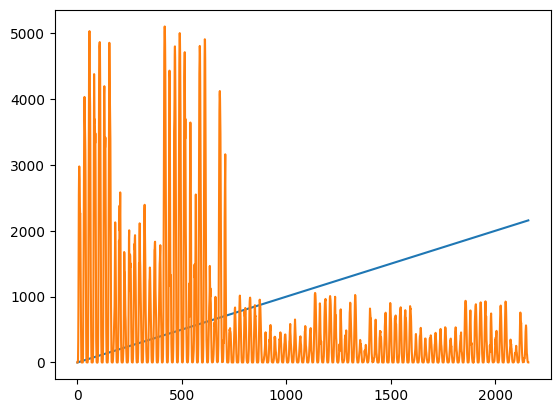

In [ ]:
# PREDS

pred = np.array(pd.read_csv("cat_preds/cat_pred_1"))*1/10

for i in range(1, 10) : 
    pred += 1/10 * np.array(pd.read_csv(f"cat_preds/cat_pred_{i}"))


plt.plot(pred)

pred = pd.DataFrame(pred).loc[:, 1:]
pred.columns = ["prediction"]

#GENERATING SUBMISSION
pred.to_csv("cat_stack_03.csv")